In [1]:
import pandas as pd
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.image as mpimg


import time
import scipy
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.metrics import AUC
from tensorflow import keras

import glob
import imageio
import matplotlib.pyplot as plt
from datetime import datetime

import IPython
import ipywidgets as widgets
import pytz # Python Timezone
import random

input_csv_path contains the csv file with the original set, every image has 6 rows, 5 rows refers to a kind of hemorrhage and the 6th shows if there's any kind. Images are indexed by a unique identifier ID
output_csv_path is the output folder that will contain a subset of the previous csv file with just a row for image and it will not contain all the dataset but a balanced subset.
input_dicom_folder contains all the images, they are organized in subfolders and their format is dicom
output_dicom_folder will contain processed images
backup_npy is a utility folder where we will save our numpy arrays

In [2]:
input_csv_path = '/eos/user/g/gamorell/test/csv_test.csv'
output_csv_path = '/eos/user/g/gamorell/test/filtered.csv'

input_dicom_folder = '/eos/user/g/gamorell/test/img'
output_dicom_folder = '/eos/user/g/gamorell/test/processed/'
output_dicom_folder_head = '/eos/user/g/gamorell/test/processed/img_'

backup_npy = '/eos/user/g/gamorell/test/npy/'

SIZE = 128               #final size of converted images
DEBUG = 0                #check converting_img()

Starting from the original csv file we select a subset of entries, we are taking into account whether an image has a hemorrhage or not, we are not considering the type and we are ignoring uncertain values (0,1). We will select all those entries where the "any" field is 1 and a subset of those where "any" is 0 of the same size of the first one, to have a balanced set.
After opening the csv file, we select rows where ID contains "any", then we take Label equal to one to make the first half of our set. We select a number of row with Label equal to zero of the same size of the first set. In the end we append the second to the first one and we save our results. 

In [3]:
def create_csv():
    raw_data = pd.read_csv(input_csv_path, usecols = ['ID', 'Label'])
    filtered = raw_data[raw_data["ID"].str.contains("_any")]
    flaired_data = filtered[filtered["Label"] == 1]
    
    unflaired_data = filtered[filtered["Label"] == 0]                          #too big (6 times the size of flaired)
    unflaired_data_head = unflaired_data.head(int(flaired_data.size/2))
    
    final_set = flaired_data.append(unflaired_data_head)
    final_set.to_csv(output_csv_path, index = False)
create_csv()


In [4]:
our_images = pd.read_csv(output_csv_path, dtype = str)
our_images

,ID,Label
0,ID_0002081b6_any,1
1,ID_0002a38ad_any,1
2,ID_000346ce2_any,1
3,ID_00042829c_any,1
4,ID_0004a5701_any,1
5,ID_00058bb06_any,1
6,ID_0005d340e_any,1
7,ID_000744022_any,1
8,ID_0007b8af4_any,1
9,ID_00083d407_any,1


The next block contains utility functions to manage paths and ID, note that results are saved in a npy file to prevent memory issues and to improve modularity. clean_str takes our previous result and it manipulate its strings to remove the "any" part, it also converts the pandas DataFrame to a numpy array. The second function create_path_list() organizes IDs to have a path for every image. os.walk scans the dicom folder and all its subfolder. At the end we save our results in a npy array. 

In [5]:
def clean_str():
    our_images = pd.read_csv(output_csv_path, dtype = str)
    pylist = our_images.values.tolist()
    for str_id in pylist:
        str_id[0] = str_id[0].rsplit('_', maxsplit = 1)[0]
    nplist = np.array(pylist).T
    np.save(backup_npy + 'data.npy', nplist)
clean_str()

def create_path_list():
    np_list = np.load(backup_npy + 'data.npy')
    file_list = []
    for root, dirs, files in os.walk(input_dicom_folder):
        for file in files:
            if(file.split('.')[0] in np_list[0]):
                file_list.append(root + '/' + file)
    
    np_file = np.array(file_list, dtype = str)
    np.save(backup_npy + 'paths.npy', np_file)
create_path_list()

In [6]:
np_list = np.load(backup_npy + 'data.npy')
np_list

array([['ID_0002081b6', 'ID_0002a38ad', 'ID_000346ce2', 'ID_00042829c',
        'ID_0004a5701', 'ID_00058bb06', 'ID_0005d340e', 'ID_000744022',
        'ID_0007b8af4', 'ID_00083d407', 'ID_0008d8433', 'ID_00094b19b',
        'ID_0009db386', 'ID_0009e5f5e', 'ID_000a050f3', 'ID_000aa2bce',
        'ID_000d66d9e', 'ID_000d69988', 'ID_000ec5e66', 'ID_000edbf38',
        'ID_00101d495', 'ID_00107f7a9', 'ID_0011ecc1b', 'ID_0011f02f5',
        'ID_001212532', 'ID_0012b5d89', 'ID_00130b866', 'ID_0013294ae',
        'ID_0015e926e', 'ID_00170833c', 'ID_001708921', 'ID_001753ad0',
        'ID_00178eb80', 'ID_0018428e1', 'ID_0018abbe1', 'ID_0019445aa',
        'ID_0019a61ed', 'ID_001af7f51', 'ID_001b1b944', 'ID_001b7abe3',
        'ID_001bb2c00', 'ID_001c0458a', 'ID_001c923b0', 'ID_001c9a9e4',
        'ID_001cc58e9', 'ID_001d37aff', 'ID_001d4ce1c', 'ID_001d83cce',
        'ID_001de8b5a', 'ID_001df2d0f', 'ID_001e00f13', 'ID_001f8e12d',
        'ID_001faa58f', 'ID_001fed527', 'ID_002011516', 'ID_0021

In [7]:
np_file = np.load(backup_npy + 'paths.npy')
np_file

array(['/eos/user/g/gamorell/test/img/ID_000039fa0.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002081b6.dcm',
       '/eos/user/g/gamorell/test/img/ID_000229f2a.dcm',
       '/eos/user/g/gamorell/test/img/ID_000230ed7.dcm',
       '/eos/user/g/gamorell/test/img/ID_00027c277.dcm',
       '/eos/user/g/gamorell/test/img/ID_000280440.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002a38ad.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002adc14.dcm',
       '/eos/user/g/gamorell/test/img/ID_0002d438a.dcm',
       '/eos/user/g/gamorell/test/img/ID_000346ce2.dcm',
       '/eos/user/g/gamorell/test/img/ID_00042829c.dcm',
       '/eos/user/g/gamorell/test/img/ID_000447d36.dcm',
       '/eos/user/g/gamorell/test/img/ID_0004a5701.dcm',
       '/eos/user/g/gamorell/test/img/ID_00058bb06.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005d340e.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005db660.dcm',
       '/eos/user/g/gamorell/test/img/ID_0005de569.dcm',
       '/eos/user/g/gamorell/te

We load our previous result with all the paths we need, we iterate through it and for every image we open it as a dicom file we convert it in an array of floating point numbers, we convert it to a PIL image to resize it and we scale it to have 8-bit values in a numpy array, at the end we round our values to integers to convert it in a png file and store it
In particular we are applying a look up table to make results "human-friendly". Using the bicubic resample we have a good compromise between quality and performance. Images are saved every iteration and different folder are used to ensure good file management for subsequent operations.

In [8]:
def converting_img():
    np_list = np.load(backup_npy + 'paths.npy')
    for count, str_path in tqdm(enumerate(np_list)):
        if(count > DEBUG):                          #to not start from the beginning in case of problems since this part lasted several hours
            dicom = pydicom.read_file(str_path)
            apply_voi_lut(dicom.pixel_array, dicom) #brightness tuning
            array = dicom.pixel_array.astype(float)
            
            image_r = Image.fromarray(array)
            image_r = image_r.resize((SIZE, SIZE),  resample = PIL.Image.BICUBIC)   #resized
            image_r = np.array(image_r)
            
            image_s = (np.maximum(image_r,0) / image_r.max()) * 255.0   #scaled
            image_s = np.uint8(image_s)
            
            data = Image.fromarray(image_s) #to png
            data.save(output_dicom_folder_head + str(int(np.floor(count/10000))) + '/' + str_path.split('/')[7].split('.')[0] + '.png')
converting_img()

138it [00:38,  3.59it/s]


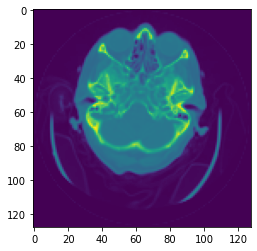

In [9]:
img = mpimg.imread('/eos/user/g/gamorell/test/processed/img_0/ID_001c828ec.png')
imgplot = plt.imshow(img)
plt.show()

The next two blocks convert our data in numpy arrays and save them, labels on the second array belong to the correspondent image given a certain index. 
img_to_npy takes every image and appends it to a images list as a numpy array, at the end we save the resulting list in a .npy file.

In [10]:
def img_to_npy():
    images = []
    for root, dirs, files in os.walk(output_dicom_folder):
        for file in files:
            images.append(np.array(Image.open(root + '/' + file)))
    train_img = np.array(images)
    np.save(backup_npy + 'train_img.npy', train_img)
img_to_npy()


labels_to_npy create a npy file with all the labels taken from the csv file, it slice the string to have just the ID, in the cycle we take every file as the last function and we look in the csv for the correspondent label, we append the label in a list and we store it as a numpy array

In [11]:
def labels_to_npy():
    data = pd.read_csv(output_csv_path) #ID_122314_any
    data["ID"] = data["ID"].str.slice(stop = 12) ##ID_122314
    labels = []
    for root, dirs, files in os.walk(output_dicom_folder):
        for file in files:
            ID = file.split('.')[0]
            labels.append(data[data["ID"] == ID].Label.values[0])
    train_labels = np.array(labels)
    np.save(backup_npy + 'train_labels.npy', train_labels)
labels_to_npy()

the next function loads the data we have just saved

In [12]:
def load():
    images = np.load(backup_npy + "train_img.npy")
    labels = np.load(backup_npy + "train_labels.npy")
    return images, labels
images, labels = load()


In [13]:
def shuffle(a, b):
    temp_arr = np.array(list(zip(a,b)))
    np.random.shuffle(temp_arr)
    a,b = zip(*temp_arr)
    return a,b
s_img, s_lbl = shuffle(images, labels)

load() function loads the files stored during the last blocks, then we shuffle those arrays keeping images and labels linked by their index in their arrays using zip(), the data_set() divides our dataset and we will have a training partition and a test partition given an original size of 215 000 images we are using 10 000 images as test data and the rest as training data.
Given our 8-bit images we want to have floating point values from 0 to 1, in the preprocess() function we divide each array by 255 to obtain that.

In [14]:
def data_set(s_img, s_lbl):
    train_img = np.split(s_img, [10])[1]
    train_lbl = np.split(s_lbl, [10])[1]
    test_img =  np.split(s_img, [10])[0]
    test_lbl =  np.split(s_lbl, [10])[0]
    return train_img, train_lbl, test_img, test_lbl
train_img, train_lbl, test_img, test_lbl = data_set(s_img, s_lbl)

def preprocess(x):
    x = x.astype(np.float32) / 255 # gray scale to floating point
    x = np.expand_dims(x, axis=3)
    return x
train_img = preprocess(train_img)
test_img = preprocess(test_img)

Our first model is the logistic regression, the input size is, coherently to our images, 128x128x1. We create the sequential model, we add layers and we return it.

In [15]:
def Logistic_Regression():
    # 2. Model Construction
    model = Sequential()
    model.add(Flatten(input_shape=(128,128,1)))
    model.add(Dense(1, activation='sigmoid'))
    return model

Our second model is a dense model, the input size is, as before, 128x128x1, we then have 4 dense layers and our activation function is always ReLU  for the first three layers and sigmoid for the output. 

In [16]:
def Dense_Model():
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 1)))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))    
    model.add(Dense(1, activation='sigmoid'))
    model.build((128, 128, 1))
    return model

Our last model is a convolutional model where we make 32 filters using a 5x5 convolution kernel, we then have a max pooling layer that uses a 2x2 input window, at the end we have two dense layer, we use ReLU for the convolution and the first dense layer and sigmoid for the output.

In [17]:
def Convolutional_Model():
    # 2. Model Construction
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(128,128,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model 

summary() shows the first part of those information you can se below, we compile our model using the loss function binary crossentropy, our optimizer is Adam and our  metric to evaluate our models is accuracy. The fit() function train our models, you can follow the process below.

In [18]:
def train(model, epochs = 11, batch_size = 64):
    model.summary()
    model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=["accuracy"])
    hist = model.fit(train_img, train_lbl, 
                 epochs=epochs, batch_size=batch_size, 
                 validation_data=(test_img, test_lbl), 
                 verbose=1)
    return hist

for each model we instatiate the architecture, we train it and at the end we save everything in a .h5 file

In [19]:
logreg_model = Logistic_Regression()
hist = train(logreg_model, epochs=7)
logreg_model.save("model/%s[%f][%f]-" % ("Logistic_Regression", hist.history['accuracy'][-1],hist.history['val_accuracy'][-1]) + datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%c") + ".h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16385     
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
2/2 [==============================] - 0s 166ms/step - loss: 1.2282 - accuracy: 0.4331 - val_loss: 0.8669 - val_accuracy: 0.5000
Epoch 2/7
2/2 [==============================] - 0s 11ms/step - loss: 0.8066 - accuracy: 0.4252 - val_loss: 0.9086 - val_accuracy: 0.5000
Epoch 3/7
2/2 [==============================] - 0s 12ms/step - loss: 0.8756 - accuracy: 0.5039 - val_loss: 0.7594 - val_accuracy: 0.5000
Epoch 4/7
2/2 [==============================] - 0s 19ms/step - loss: 0.6536 - accuracy: 0.6063 - v

In [20]:
dense_model = Dense_Model()
hist = train(dense_model, epochs=8)
dense_model.save("model/%s[%f][%f]-" % ("Dense_Model", hist.history['accuracy'][-1],hist.history['val_accuracy'][-1]) + datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%c") + ".h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,231,617
Trainable params: 4,231,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
2/2 [==============================] - 0s 95ms/step - loss: 0.7789 - accuracy: 0.5039 - val_loss: 3.

In [21]:
cnn_model = Convolutional_Model()
hist = train(cnn_model, epochs=11)
cnn_model.save("model/%s[%f][%f]-" % ("Conolutional_Model", hist.history['accuracy'][-1],hist.history['val_accuracy'][-1]) + datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%c") + ".h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3936288   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,937,153
Trainable params: 3,937,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/11
2/2 [==============================] - 0s 142ms/step - loss: 1.2195 - accuracy: 0.4961 - val_loss: 

at the end we show some results, predicting labels of our test set and comparing it to our original labels we compute accuracy and the confusion matrix, we then plot the ROC curve.

In [23]:
def plotting(model):
    pr_cl = (model.predict(test_img) > 0.5).astype("int32")
    print(accuracy_score(test_lbl.T, pr_cl))
    print(confusion_matrix(test_lbl.T, pr_cl))
    y_pred_keras = model.predict(test_img).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_lbl, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

0.6
[[4 1]
 [3 2]]


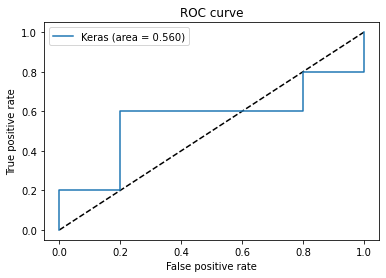

In [24]:
plotting(logreg_model)

0.8
[[5 0]
 [2 3]]


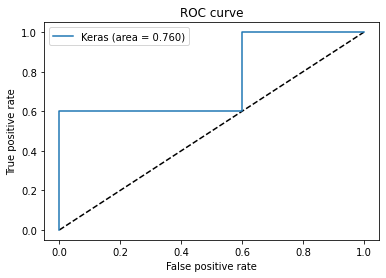

In [25]:
plotting(dense_model)

0.7
[[5 0]
 [3 2]]


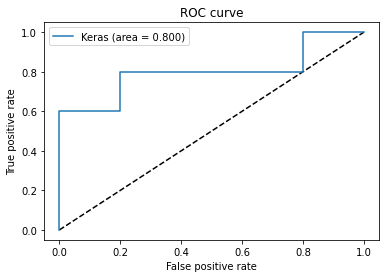

In [26]:
plotting(cnn_model)